In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shakesphere/shakespeare.txt


# Main code in ``Bigram.py``

# Preparing the dataset

## 1.1) Opening the data

In [2]:
with open(r'/kaggle/input/shakesphere/shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
print("The length of the text is", len(text))

The length of the text is 1115394


In [4]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



## 1.2) Tokenization

In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}

print(stoi, '\n\n', itos)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64} 

 {0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 46: 'h', 47: '

In [6]:
encode = lambda s: [stoi[i] for i in s]
decode = lambda l: ''.join([itos[i] for i in l])

print(encode("hii there"))
decode(encode("chichen itza"))

[46, 47, 47, 1, 58, 46, 43, 56, 43]


'chichen itza'

In [7]:
print(encode(text[:100]))
print()
print(decode(encode(text[:100])))

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56, 53, 41, 43, 43, 42, 1, 39, 52, 63, 1, 44, 59, 56, 58, 46, 43, 56, 6, 1, 46, 43, 39, 56, 1, 51, 43, 1, 57, 54, 43, 39, 49, 8, 0, 0, 13, 50, 50, 10, 0, 31, 54, 43, 39, 49, 6, 1, 57, 54, 43, 39, 49, 8, 0, 0, 18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 37, 53, 59]

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [8]:
data = torch.tensor(encode(text), dtype=torch.long)

print(f"The shape of the data: {data.shape}")
print(f"Data type: {data.dtype}")
print("--"*25+'\n')
print(f"The first 100 characters of the data:\n{data[:100]}")
print()
print(f"The first 100 characters of the data:\n{decode(data[:100].tolist())}")

The shape of the data: torch.Size([1115394])
Data type: torch.int64
--------------------------------------------------

The first 100 characters of the data:
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])

The first 100 characters of the data:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


## 1.3) Train-Val split

In [9]:
n1 = int(0.9*len(data))
train_data = data[:n1]
val_data = data[n1:]
len(train_data), len(val_data), len(train_data)+len(val_data), len(data)

(1003854, 111540, 1115394, 1115394)

## 1.4) Create Dataloader

In [10]:
block_size = 8

In [11]:
x = train_data[:block_size]
y = train_data[1:block_size+1]

for i in range(block_size):
    context = x[:i+1]
    out = y[i]
    print(f"When the input tensor is {context.tolist()}, the target is {out}")

When the input tensor is [18], the target is 47
When the input tensor is [18, 47], the target is 56
When the input tensor is [18, 47, 56], the target is 57
When the input tensor is [18, 47, 56, 57], the target is 58
When the input tensor is [18, 47, 56, 57, 58], the target is 1
When the input tensor is [18, 47, 56, 57, 58, 1], the target is 15
When the input tensor is [18, 47, 56, 57, 58, 1, 15], the target is 47
When the input tensor is [18, 47, 56, 57, 58, 1, 15, 47], the target is 58


In [12]:
torch.manual_seed(1337)
batch_size = 4 #number of independant examples processed in parallel
block_size = 8 #maximum context length for predictions

# number of input examples = batch size * block size

def get_batch(split):
    # select the appropriate dataset
    data = train_data if split == "train" else val_data
    
    #Generate random indices
    idx = torch.randint(0,len(data)-block_size, (batch_size,))
    
    #Select a block of text of size block_size starting from each random index
    x = torch.stack([data[i:i+block_size] for i in idx])
    
    #Shift the selected block of text by one character to derive the target set
    y = torch.stack([data[i+1:i+block_size+1] for i in idx])
    
    return x,y

xb, yb = get_batch("train")
print(f"Shape of input: {xb.shape}\nInputs: {xb}\n")
print(f"Shape of targets: {yb.shape}\nTargets: {yb}")

Shape of input: torch.Size([4, 8])
Inputs: tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])

Shape of targets: torch.Size([4, 8])
Targets: tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


In [13]:
for b in range(batch_size): #batch dimension
    for i in range(block_size): #called the time dimension
        context = xb[b,:i+1]
        target = yb[b,i]
        print(f"When the input tensor is {context.tolist()}, the target is {target}")
    print()

When the input tensor is [24], the target is 43
When the input tensor is [24, 43], the target is 58
When the input tensor is [24, 43, 58], the target is 5
When the input tensor is [24, 43, 58, 5], the target is 57
When the input tensor is [24, 43, 58, 5, 57], the target is 1
When the input tensor is [24, 43, 58, 5, 57, 1], the target is 46
When the input tensor is [24, 43, 58, 5, 57, 1, 46], the target is 43
When the input tensor is [24, 43, 58, 5, 57, 1, 46, 43], the target is 39

When the input tensor is [44], the target is 53
When the input tensor is [44, 53], the target is 56
When the input tensor is [44, 53, 56], the target is 1
When the input tensor is [44, 53, 56, 1], the target is 58
When the input tensor is [44, 53, 56, 1, 58], the target is 46
When the input tensor is [44, 53, 56, 1, 58, 46], the target is 39
When the input tensor is [44, 53, 56, 1, 58, 46, 39], the target is 58
When the input tensor is [44, 53, 56, 1, 58, 46, 39, 58], the target is 1

When the input tensor i

# Bigram Language Model

Simplest Language Model

In [14]:
torch.manual_seed(1337)

## 2.1) Creating the model

In [15]:
class BigramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, idx, targets=None):
        # shape of idx and targets: (B,T) tensor
        logits = self.token_embedding_table(idx) #(B,T,C) = (4,8,65)
        
        if targets ==None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        #idx is (B,T) array tensor of indices in the current context
        for i in range(max_new_tokens):
            #get the logits for the next token
            logits, loss = self.forward(idx)
            #focusing on the only the last time step
            logits = logits[:, -1, :] #get the last time step for each sequence, shape: (B,C)
            #convert to probs using softmax
            probs = F.softmax(logits, dim=-1)
            #sample out an index
            idx_next = torch.multinomial(probs, num_samples=1)
            #append to existing index
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [16]:
m = BigramLanguageModel(vocab_size)
logits, loss = m.forward(xb,yb)

print(f"logits shape: {logits.shape}")
print(f"loss: {loss} | we are expecting a loss of around {torch.log(torch.tensor(vocab_size))}")

logits shape: torch.Size([32, 65])
loss: 4.878634929656982 | we are expecting a loss of around 4.174387454986572


In [17]:
idx = torch.zeros((1,1), dtype=torch.long)
generated = m.generate(idx, 300)
decode(generated[0].tolist())

"\nSr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3!dcbf?pGXepydZJSrF$Jrqt!:wwWSzPNxbjPiD&Q!a;yNt$Kr$o-gC$WSjJqfBKBySKtSKpwNNfyl&w:q-jluBatD$Lj;?yzyUca!UQ!vrpxZQgC-hlkq,ptKqHoiX-jjeLJ &slERj KUsBOL!mpJO!zLg'wNfqHAMgq'hZCWhu.W.IBcP \nRFJ&DEs,nw?pxE?xjNH"

## 2.2 Training the Model

In [18]:
#Pytorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)
lossi=[]
batch_size = 32

for steps in range(10000):
    xb, yb = get_batch("train")
    
    #evaluate the loss
    logits, loss = m.forward(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    lossi.append(loss.log10().item())

print(loss.item())

2.4727132320404053


In [19]:
print(decode(m.generate(torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


Jund wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZAnde.
athave l.
KEONH:
ARThanco be y,-hedarwnoddy scace, tridesar, wnl'shenous s ls, theresseys
PlorseelapinghiybHen yof GLUCEN t l-t E:
I hisgothers je are!-e!
QLYotouciullle'z,
Thitertho s?
NDan'spererfo cist ripl chys er orlese;
Yo jehof h hecere ek? wferommot mowo soaf yoit, ince his, t, f at. fal whetrimy bupof tor atha Bu!
JOutho f cimimave.
NEDUSt cir selle p wie wede


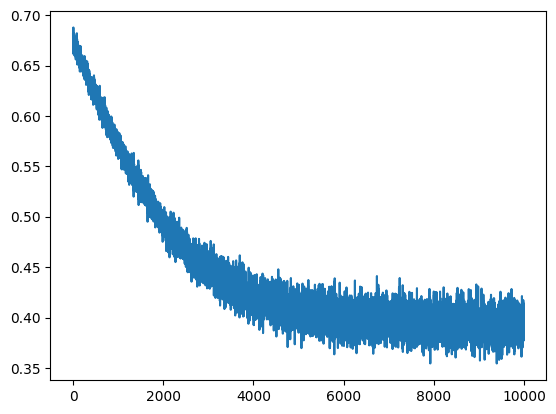

In [20]:
plt.plot(lossi)

# 3- Self Attention Trick (Averaging the previous tokens embeddings)

we need each token commuinicate with all previous tokens, for example: the 5th token communicate with 1st, 2nd, 3rd, 4th tokens

since we are predicting the next token, we need to consider the previous tokens only

The easiset way to make them communicate is averaging the previous tokens embeddings (it's kinda lossy since we are losing the spatial information)

In [21]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [22]:
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 32])

### For loops

In [23]:
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)

### Matrix Multiplication for Self-Attention

In [24]:
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow2[0], xbow[0])

True

### Softmax for Self-Attention

In [25]:
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=1)
xbow3 = wei @ x
torch.allclose(xbow2, xbow3)

True

### Version 4 Self-Attention
Single head perform Self-Attention

In [26]:
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

k = key(x) #(B,T,16)
q = query(x) #(B,T,16)
wei = q @ k.transpose(-2,-1) #(B,T,16) @ (B,16,T) = (B,T,T)

tril = torch.tril(torch.ones(T,T))
# wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=1)

v = value(x) # (B,T,head_size)
out = wei @ v #(B,T,T) @ (B,T,head_size) = (B,T,head_size)

out.shape

torch.Size([4, 8, 16])

In [27]:
wei[0]

tensor([[0.0248, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0052, 0.0091, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0521, 0.0135, 0.2482, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3171, 0.0214, 0.1642, 0.1188, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0412, 0.0487, 0.1046, 0.0742, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1060, 0.5347, 0.2059, 0.1030, 0.7402, 0.0192, 0.0000, 0.0000],
        [0.4298, 0.3409, 0.1769, 0.2027, 0.0480, 0.8472, 0.2329, 0.0000],
        [0.0238, 0.0316, 0.1002, 0.5013, 0.0117, 0.1336, 0.7671, 1.0000]],
       grad_fn=<SelectBackward0>)

### Our BatchNorm1D

In [28]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # batch mean
            xmean = x.mean(0, keepdim= True)
            # batch variance
            xvar = x.var(0, keepdim= True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

torch.manual_seed(1337)
module = BatchNorm1d(100)
x = torch.randn(32, 100)
x = module(x)
x.shape

# columns are normalized
print(f"mean of first column: {x[:, 0].mean():.4f} | std of first column: {x[:, 0].std():.4f}")
# rows are not normalized ➡️ we need to normalize the rows instead
print(f"mean of first row: {x[0, :].mean():.4f} | std of first row: {x[0, :].std():.4f}")

mean of first column: 0.0000 | std of first column: 1.0000
mean of first row: 0.0411 | std of first row: 1.0431


### V/s LayerNorm

In [29]:
# after normalizing the rows (and removing the buffers too)
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        xmean = x.mean(1, keepdim= True)
        xvar = x.var(1, keepdim= True)
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

torch.manual_seed(1337)
module = BatchNorm1d(100)
x = torch.randn(32, 100)
x = module(x)
x.shape

# columns are not normalized now
print(f"mean of first column: {x[:, 0].mean():.4f} | std of first column: {x[:, 0].std():.4f}")
# rows are normalized now
print(f"mean of first row: {x[0, :].mean():.4f} | std of first row: {x[0, :].std():.4f}")

mean of first column: 0.1469 | std of first column: 0.8803
mean of first row: -0.0000 | std of first row: 1.0000
